In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt

In [2]:
transform=transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
train_dir = '/kaggle/input/potholehumpvgg/customdataset/train'
val_dir = '/kaggle/input/potholehumpvgg/customdataset/test'
test_dir = '/kaggle/input/vggtest/vggtest'
train_dataset = datasets.ImageFolder(train_dir, transform)
val_dataset = datasets.ImageFolder(val_dir, transform)
test_dataset = datasets.ImageFolder(test_dir, transform)

In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
# Define VGG16 model
vgg16 = models.vgg16(pretrained=True)
# Modify the last fully connected layer to match the number of classes
num_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_features, len(train_dataset.classes))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 169MB/s]


In [6]:
# Train the model
num_epochs = 100
best_val_accuracy = 0.0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)

for epoch in range(num_epochs):
    vgg16.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}")
    
     # Validation
    vgg16.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg16(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    # Save the model if validation accuracy is improved
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(vgg16.state_dict(), 'best_model.pth')


Epoch [1/100], Train Loss: 0.0634
Validation Accuracy: 0.9574
Epoch [2/100], Train Loss: 0.0049
Validation Accuracy: 0.9574
Epoch [3/100], Train Loss: 0.0004
Validation Accuracy: 0.9787
Epoch [4/100], Train Loss: 0.0001
Validation Accuracy: 0.9787
Epoch [5/100], Train Loss: 0.0001
Validation Accuracy: 0.9787
Epoch [6/100], Train Loss: 0.0001
Validation Accuracy: 0.9787
Epoch [7/100], Train Loss: 0.0000
Validation Accuracy: 0.9787
Epoch [8/100], Train Loss: 0.0000
Validation Accuracy: 0.9787
Epoch [9/100], Train Loss: 0.0000
Validation Accuracy: 0.9787
Epoch [10/100], Train Loss: 0.0000
Validation Accuracy: 0.9787
Epoch [11/100], Train Loss: 0.0000
Validation Accuracy: 0.9787
Epoch [12/100], Train Loss: 0.0000
Validation Accuracy: 0.9787
Epoch [13/100], Train Loss: 0.0000
Validation Accuracy: 0.9787
Epoch [14/100], Train Loss: 0.0000
Validation Accuracy: 0.9787
Epoch [15/100], Train Loss: 0.0000
Validation Accuracy: 0.9787
Epoch [16/100], Train Loss: 0.0000
Validation Accuracy: 0.9787
E

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [8]:
classes = ['hump', 'pothole']

In [9]:
# Test the best model
vgg16.load_state_dict(torch.load('best_model.pth'))
vgg16.eval()
correct = 0
total = 0
predictions = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vgg16(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

# Convert predictions and true labels to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)



test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9939


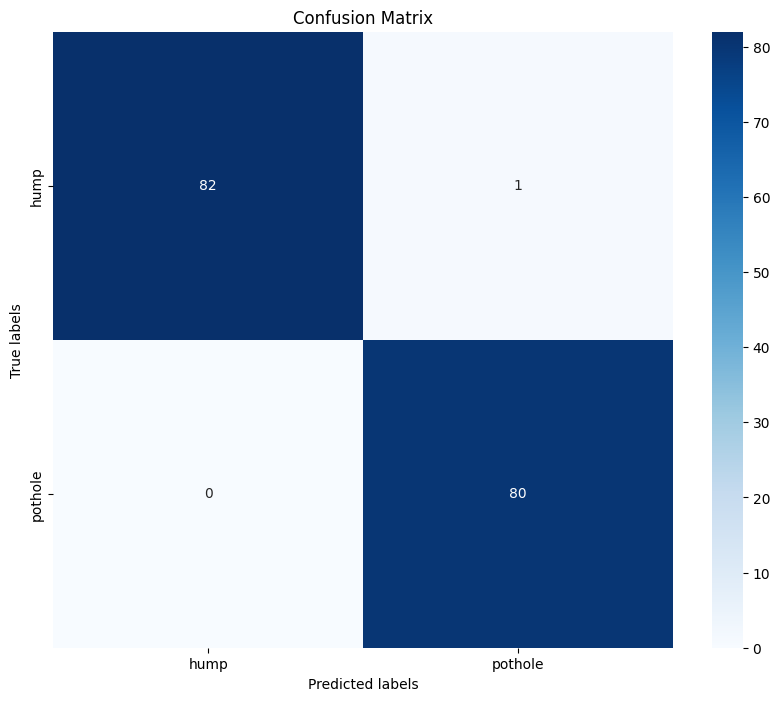

In [10]:

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [11]:
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        83
           1       0.99      1.00      0.99        80

    accuracy                           0.99       163
   macro avg       0.99      0.99      0.99       163
weighted avg       0.99      0.99      0.99       163

